In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 10 seconds. 424 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage = -0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [8]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [9]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test ODE Layer

In [10]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [11]:
ps_phase2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
            layer_2 = ())

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = ())

In [12]:
p0, _ = to_phase(x, ps_phase2, st_phase)

([0.9621183521796359 0.14853194706872877 … 0.17156837979634934 0.2207192722515445; -0.7507570041684075 0.867429651787117 … -0.4410375489659723 -0.15208475266136406], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

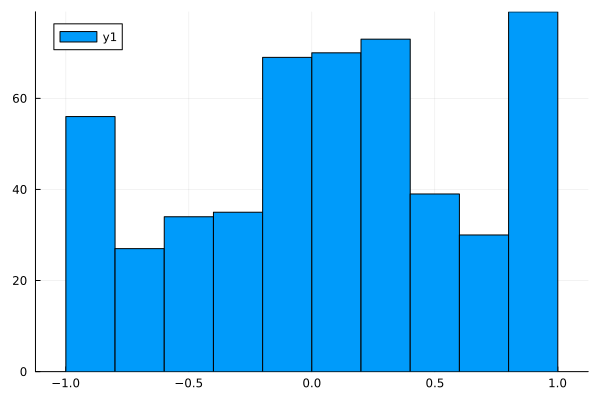

In [13]:
histogram(vec(p0))

In [14]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [15]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [16]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [18]:
xfn = phase_to_current(x, spk_args=spk_args)

(::Main.PhasorNetworks.var"#inner#80"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

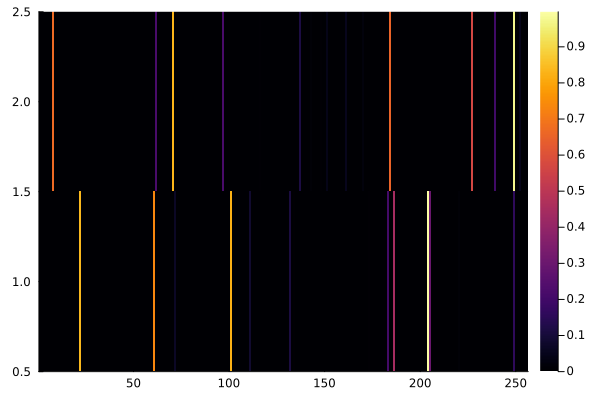

In [19]:
heatmap(xfn(1.2))

In [20]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [21]:
using SciMLSensitivity

In [25]:
import .PhasorNetworks: PhasorODE

In [30]:
function PhasorODE(model::Lux.AbstractExplicitLayer; 
    solver = Tsit5(),
    sensealg = InterpolatingAdjoint(; autojacvec=ZygoteVJP()),
    tspan::Tuple{<:Real, <:Real} = (0.0, 30.0),
    spk_args::SpikingArgs = SpikingArgs(),
    dt::Real = 0.1,
    offset::Real = 0.0,
    static_bias::Function = x -> ones(ComplexF32, size(x)),
    dense::Bool = true,)

    return PhasorODE(model, solver, sensealg, tspan, spk_args, dt, offset, static_bias, dense)
end

PhasorODE

In [46]:
using ChainRulesCore: ignore_derivatives

In [35]:
#forward pass
function (n::PhasorODE)(currents, ps, st)
    #sample the input & output to determine size of the state
    i0 = currents(0.0)
    y0, _ = n.model(i0, ps, st)
    u0 = zeros(ComplexF32, size(y0))
    bias = n.static_bias(u0)

    #define the function which updates neurons' potentials
    function dudt(u, p, t)
        du_real, _ = n.model(currents(t), p, st)
        constant = n.spk_args.leakage + 2*pi*im / n.spk_args.t_period
        du = constant .* u .+ du_real
        ignore_derivatives() do:
            du .+= bias_current(bias, t, n.offset, n.spk_args)
        end
        return du
    end

    
    prob = ODEProblem(dudt, u0, n.tspan, ps)
    if n.dense
        #save the full solution with interpolation
        soln = solve(prob, n.solver, 
            adaptive = false, 
            dt = n.dt, 
            saveat = n.tspan[1]:n.dt:n.tspan[2], 
            sensealg = n.sensealg,
            save_start = true)
    else
        #only save the final output (used with backprop)
        soln = solve(prob, n.solver, 
            adaptive = false, 
            dt = n.dt, 
            saveat = n.tspan[2], 
            sensealg = n.sensealg,
            save_start = false)
    end
    
    return soln, st
end

In [36]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), 
                                sensealg=GaussAdjoint(),
                                tspan = (0.0, 10.0), 
                                dt = solver_args[:dt],
                                dense = true),)

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#43),
    layer_3 = WrappedFunction(#44),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [37]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.034017395 -0.051840298; 0.20458257 -0.1745663; … ; -0.016001472 0.07038248; -0.14254059 -0.1955896], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [38]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dudt#42"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, GaussAdjoint{0, true, Val{:central}, Nothing}, Tuple{Float64, Float64}}, Main.PhasorNetworks.var"#inner#80"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}, Matrix{ComplexF32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_li

In [39]:
p_sol = potential_to_phase(Array(y_sol), y_sol.t, offset=0.0, spk_args=spk_args);

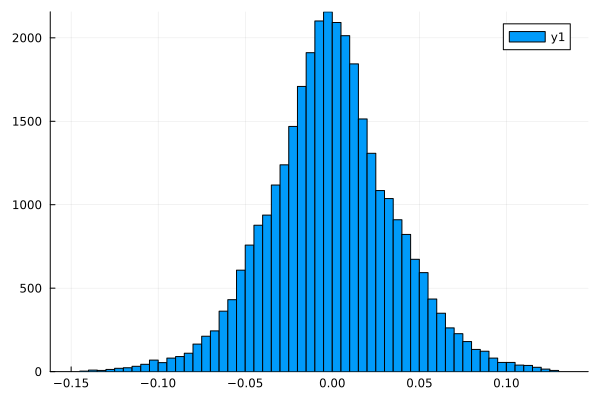

In [40]:
mp = mean_phase(y_sol, 1, spk_args=spk_args, offset=0.0)
histogram(vec(mp))

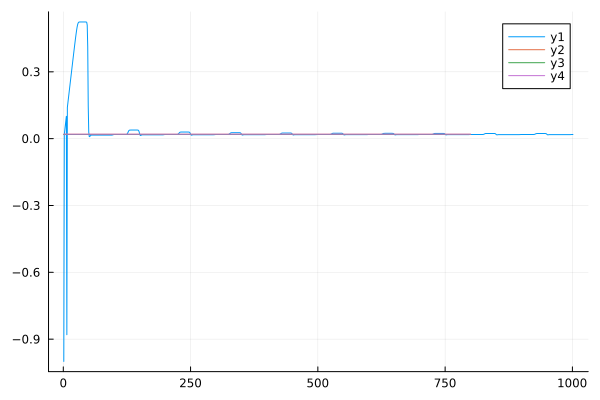

In [41]:
plot(p_sol[1,1,:])
plot!(mean(p_sol[1,1,201:end]) .* ones(1001-201))
plot!(median(p_sol[1,1,201:end]) .* ones(1001-201))
plot!(mp[1,1] .* ones(1001 - 201))

In [42]:
mp[1,1]

0.019879559354795077

In [43]:
mean(mean_phase(sol_model(x, ps_sol, st_sol)[1], 1, offset=0.0, spk_args=spk_args))

-0.0006379315180061952

In [44]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.034017395 -0.051840298; 0.20458257 -0.1745663; … ; -0.016001472 0.07038248; -0.14254059 -0.1955896], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))

In [45]:
withgradient(p -> mean(mean_phase(sol_model(x, p, st_sol)[1], 1, offset=0.0, spk_args=spk_args)), psf_sol)

┌ Warning: Automatic AD choice of autojacvec failed in ODE adjoint, failing back to ODE adjoint + numerical vjp
└ @ SciMLSensitivity ~/.julia/packages/SciMLSensitivity/bspwn/src/sensitivity_interface.jl:381


LoadError: ArgumentError: Cannot create a dual over scalar type ComplexF32. If the type behaves as a scalar, define ForwardDiff.can_dual(::Type{ComplexF32}) = true.

In [69]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), 
                                sensealg=GaussAdjoint(),
                                tspan = (0.0, 10.0), 
                                dt = solver_args[:dt]),
                    x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0),
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#59),
    layer_3 = WrappedFunction(#60),
    layer_4 = PhasorODE(
        model = Dense(2 => 128, tanh_fast),  # 384 parameters
    ),
    layer_5 = WrappedFunction(#61),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [ ]:
#debug - see where the PhasorODE and normal dense layer diverge

In [70]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [71]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.31196022122112305 -0.922761559481565 … 0.03241910651303902 0.5191580797012283; -0.1646224016692037 -0.5884893907672847 … -0.12047592873922391 0.8657846526536085], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [72]:
y_ode

2×256 Matrix{Float64}:
 -0.31196   -0.922762  0.442748  0.614379  …  0.534884   0.0324191  0.519158
 -0.164622  -0.588489  0.360606  0.893705     0.282076  -0.120476   0.865785

In [73]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [74]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

1.002703073996027

In [75]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.0027030725807178, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.012282577 -0.010785907; 0.011067843 0.0005904216; … ; 0.0073633967 -0.033248678; 0.018699411 0.04831563], bias = Float32[0.016210143; 0.12460526; … ; 0.18073948; -0.14220095;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.003176278 -0.002335799 … 0.003046193 -0.0024066165; -0.020693118 -0.023554409 … 0.018714761 -0.014605872], bias_real = Float32[-0.0076467567, -0.0487321], bias_imag = Float32[-0.0104041835, -0.02990902])),))

In [76]:
ps_ode2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
        layer_2 = ps_ode.layer_2,
        layer_3 = ps_ode.layer_3,
        layer_4 = ps_ode.layer_4,
        layer_5 = ps_ode.layer_5,
        layer_6 = ps_ode.layer_6)

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [77]:
psf = ComponentArray(ps_ode2)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [78]:
args.epochs = 5

5

In [79]:
losses, ps_train, st_train = train(ode_model, psf, st_ode, train_loader, args, verbose=true)

[ Info: Training on CPU


Epoch 1 loss: 0.9310763238817259
Epoch 1 loss: 1.0960399250219526
Epoch 1 loss: 1.1042742269044645
Epoch 1 loss: 1.1168462709127351
Epoch 1 loss: 1.0122992916204758
Epoch 1 loss: 0.9713118096291574
Epoch 1 loss: 0.9327985693036679
Epoch 1 loss: 0.8451744363679031
Epoch 1 loss: 0.9654904354190276
Epoch 1 loss: 0.8144524937437749
Epoch 1 loss: 0.9908457960177187
Epoch 1 loss: 0.8661033963514436
Epoch 1 loss: 0.939326019475518
Epoch 1 loss: 0.8805251235313131
Epoch 1 loss: 0.9229966470542326
Epoch 1 loss: 0.8491463356174725
Epoch 1 loss: 0.889026062976122
Epoch 1 loss: 0.8779083675143117
Epoch 1 loss: 0.9499814405627438
Epoch 1 loss: 0.9266423480408873
Epoch 1 loss: 0.8797619247231977
Epoch 1 loss: 0.7988594229416784
Epoch 1 loss: 0.8624304304820283
Epoch 1 loss: 0.9378474664934507
Epoch 1 loss: 0.9116224617220334
Epoch 1 loss: 0.8783499805099754
Epoch 1 loss: 0.9301181888478058
Epoch 1 loss: 0.9144442959900767
Epoch 1 loss: 0.817377016279284
Epoch 1 loss: 0.8333220581842955
Epoch 1 loss:

(Any[0.9310763238817259, 1.0960399250219526, 1.1042742269044645, 1.1168462709127351, 1.0122992916204758, 0.9713118096291574, 0.9327985693036679, 0.8451744363679031, 0.9654904354190276, 0.8144524937437749  …  0.2806210004487303, 0.26961559576555866, 0.2976043602835779, 0.2892461417705919, 0.2952465140133938, 0.263109063858067, 0.30107478359546, 0.2782492765084929, 0.29315721688386726, 0.2717234241396065], (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.11232285 -0.15168968; -0.025347667 -0.09064814; … ; 0.057213306 0.06549642; -0.15352944 0.05557236], bias = Float32[0.03443973; -0.002265588; … ; -0.03946986; 0.0054282015;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.8069251 -0.1767935 … -1.0794894 -0.119684815; -0.35287797 -0.5887308 … -0.77324176 0.6498305], bias_real = Float32[1.172605, 1.0762905], bias_imag = Float32[0.0551556, 0.022737948])), (layer_1 =

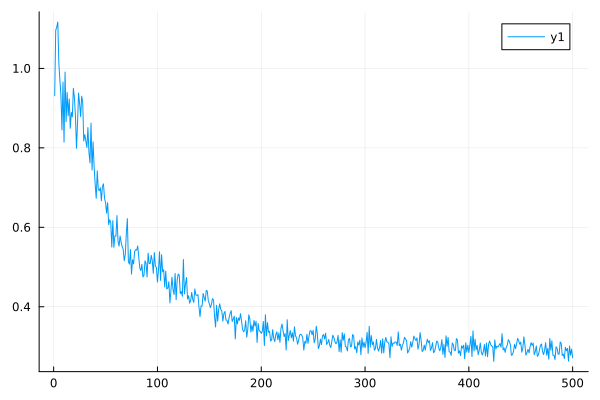

In [80]:
plot(losses)

In [81]:
ps_train .- psf

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.01386109 -0.008276969; -0.031471133 0.023177683; … ; -0.058252238 0.03978894; -0.004315689 -0.0025213212], bias = Float32[0.03443973; -0.002265588; … ; -0.03946986; 0.0054282015;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.020494401 0.046853676 … -0.012072682 -0.04045091; -0.0070267916 0.005394876 … 0.0143103 -0.019349515], bias_real = Float32[0.17260504, 0.07629049], bias_imag = Float32[0.0551556, 0.022737948]))

In [82]:
loss_and_accuracy(test_loader, ode_model, ps_train, st_train)

(0.28293904730103475, 0.683984375)

In [83]:
loss_and_accuracy(test_loader, ode_model, ps_train, st_train)

(0.28293904730103475, 0.683984375)